<figure>
  <IMG SRC="logo_stowa.jpg" WIDTH=250 ALIGN="right">
      
</figure>
   
# Notebook 1: Voorspellen
*auteur: S. Klop*
    
In dit notebook wordt behandelt hoe, met behulp van tijdreeksanalyse een hydrologische systeem kan worden geanalyseerd. Hierbij wordt gekeken naar een netwerk van meerdere peilbuizen. Vanuit de tijdreeksmodellen opgesteld voor deze peilbuizen kan informatie over het systeem worden verkregen.





## Verlagingskegel onttrekking

In [17]:
# inladen van de benodigde python packages
import pastas as ps
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import HTML
import os
%matplotlib inline
ps.set_log_level("ERROR")


In de omgeving een natuurgebied bevindt zich een onttrekking voor een groot industrieel complex. Bij het waterschap is het vermoeden dat deze onttrekking mogelijk leid tot een verlaging van de grondwaterstand in het gebied, terwijl dit voor de vergunningsverlening niet toegestaan is. Het waterschap besluit daarom te kijken of op basis van peilgegevens kan worden aangetoond of de onttrekking op een afstand van ca. 500 m tot aan het natuurgebied voor verlagingen heeft gezorgd. Dit wordt onderzocht met behulp van tijdreeksanalyse.

Rondom de onttrekking heeft het waterschap peilbuisgegevens beschikbaar van de peilbuizen PB1, PB2 en PB3. Deze peilbuizen hebben relatief lange meetreeksen met elke een eigen start en eind periode. Helaas meten geen van deze peilbuizen de stijghoogte meer in de afgelopen jaren. In de onderstaande afbeeldingen zijn de meetreeksen van de peilbuizen weergeven. 

De afstanden van de peilbuizen tot aan de onttrekking zijn bepaald. Deze zijn te zien in de onderstaande tabel.

| Peilbuis      | Afstand  [m]  | 
| ------------- |:-------------:| 
| PB1           | 112           | 
| PB2           | 180           | 
| PB3           | 321           |


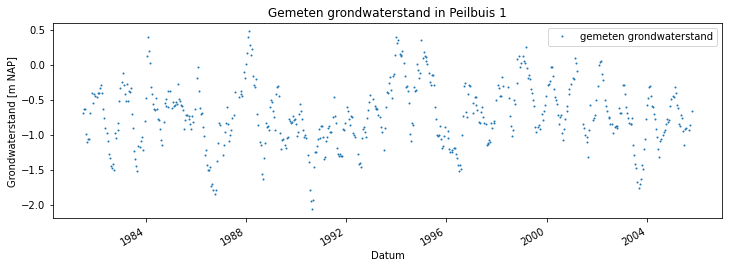

In [3]:
PB1 = pd.read_csv("data/PB1_c.csv", parse_dates=True, index_col="date", squeeze=True)

# plotten van de grondwaterstand
fig, ax = plt.subplots(1, 1, figsize=(12,4))
PB1.plot(ax=ax, color='C0', ls='', marker='.', markersize=2)

# opmaken van de figuur
ax.set_ylabel('Grondwaterstand [m NAP]')
ax.set_xlabel('Datum')
ax.set_title('Gemeten grondwaterstand in Peilbuis 1')
ax.legend([f'gemeten grondwaterstand']);

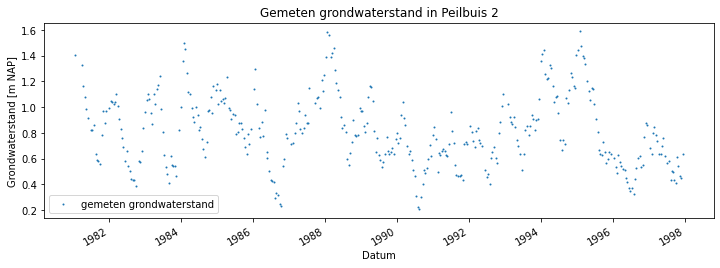

In [4]:
PB2 = pd.read_csv("data/PB2_c.csv", parse_dates=True, index_col="date", squeeze=True)

# plotten van de grondwaterstand
fig, ax = plt.subplots(1, 1, figsize=(12,4))
PB2.plot(ax=ax, color='C0', ls='', marker='.', markersize=2)

# opmaken van de figuur
ax.set_ylabel('Grondwaterstand [m NAP]')
ax.set_xlabel('Datum')
ax.set_title('Gemeten grondwaterstand in Peilbuis 2')
ax.legend([f'gemeten grondwaterstand']);

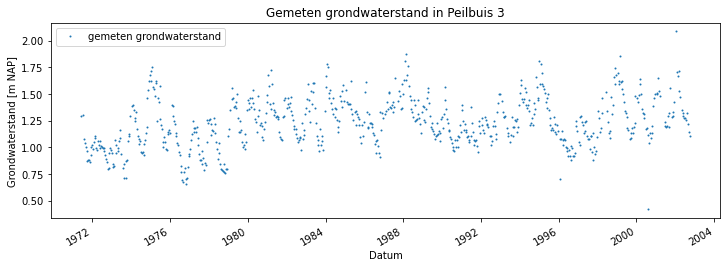

In [5]:
PB3 = pd.read_csv("data/PB3_c.csv", parse_dates=True, index_col="date", squeeze=True)

# plotten van de grondwaterstand
fig, ax = plt.subplots(1, 1, figsize=(12,4))
PB3.plot(ax=ax, color='C0', ls='', marker='.', markersize=2)

# opmaken van de figuur
ax.set_ylabel('Grondwaterstand [m NAP]')
ax.set_xlabel('Datum')
ax.set_title('Gemeten grondwaterstand in Peilbuis 3')
ax.legend([f'gemeten grondwaterstand']);

Om een tijdreeksmodel op te stellen voor grondwatermeetreeks wordt gebruik gemaakt van de neerslag en verdamping. Hiervoor zijn de gegevens gebruikt van het dichtsbijzijnde weerstation van het KNMI. De neerslag en verdamping zijn te zien in de onderstaande afbeelding. Voor alle peilbuizen is dit weerstation het dichtsbijzijnde.


INFO: Nan-values were removed at the start of the time series EV24 260.
INFO: Inferred frequency for time series EV24 260: freq=D
INFO: Nan-values were removed at the start of the time series RH 260.
INFO: Inferred frequency for time series RH 260: freq=D
INFO: Time Series RH 260: 30 nan-value(s) was/were found and filled with: 0.0.


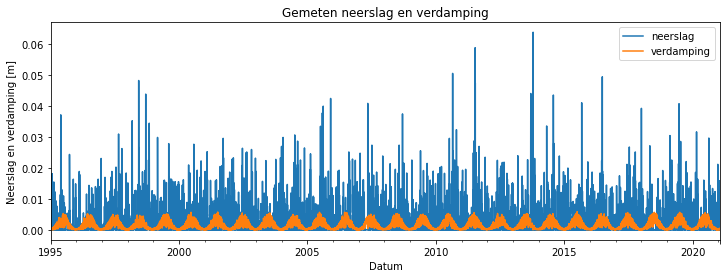

In [16]:
verdamping = ps.read_knmi("data/etmgeg_260.txt", variables="EV24").series 
neerslag = ps.read_knmi("data/etmgeg_260.txt", variables="RH").series 

# plotten van de neerslag en verdamping
fig, ax = plt.subplots(1, 1, figsize=(12,4))
neerslag.plot(ax=ax, color='C0')
verdamping.plot(ax=ax, color='C1')

# opmaken van de figuur
ax.set_ylabel('Neerslag en verdamping [m]')
ax.set_xlabel('Datum')
ax.set_title('Gemeten neerslag en verdamping')
ax.legend([f'neerslag',
          f'verdamping']);
ax.set_xlim(xmin='1995');

Om uit te zoeken wat het effect is van de onttrekking op de gemeten stijghoogte is bij de eigenaar van de onttrekking de meetreeks voor de onttrekking opgehaald. De onttrekking is opgestart in de jaren 60. De onttrekking variert door de jaren heen.

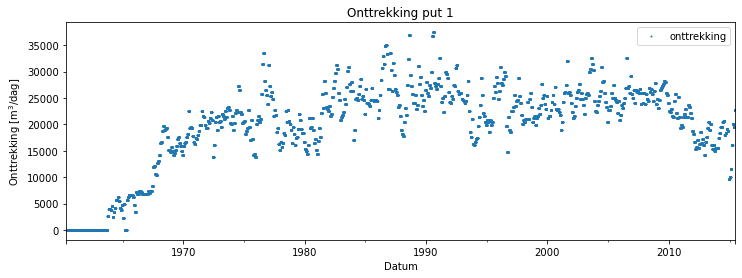

In [6]:
well = pd.read_csv("data/well.csv", index_col=0, parse_dates=True, squeeze=True)

# plotten van de grondwaterstand
fig, ax = plt.subplots(1, 1, figsize=(12,4))
well.plot(ax=ax, color='C0', ls='', marker='.', markersize=2)

# opmaken van de figuur
ax.set_ylabel('Onttrekking [m$^3$/dag]')
ax.set_xlabel('Datum')
ax.set_title('Onttrekking put 1')
ax.legend([f'onttrekking']);

### Opstellen van het tijdreeksmodel

De eerste stap voor het opstellen van het model is het toevoegen van de grondwater observaties aan het model. Voor een eerste berekening wordt de grondwater reeks gebruikt tot aan de huidige datum (niet de "toekomstige" grondwaterstand). In de reeks zijn geen uitschieters gevonden, er is daarom geen reden om de meetreeks voor te bewerken.

De neerslag en verdamping worden toegevoegd aan het model als verklarende reeksen. Om de verklaarende reeksen toe te voegen moet een `respons functie` worden toegekent aan de verklarende reeks (in dit geval regen en verdamping). De respons functie beschrijft de reactie van de grondwaterstand op een externe invloed. Deze moet worden vastgesteld voor elke verklarende reeks, waarbij de gebruiker het type respons functie kiest en waarbij het tijdreeksmodel de parameters van deze functie optimaliseerd. Voor het tijdreeksmodel wordt gebruikt gemaakt van de Gamma respons functie voor de neerslag en verdamping. 

In het tijdreeksmodel wordt dezelfde response functie gebruikt voor de neerslag en de verdamping. Hierbij wordt het verband tussen de neerslag en verdamping beschreven met de formule:

$ R = P - f * E$

waarbij $R$ de grondwateraanvulling is [m], $P$ de neerslag [m], $f$ de verdampingsfactor [-] en $E$ de verdamping [m]. De verdampingsfactor wordt door het tijdreeksmodel geoptimaliseerd naast de parameters voor de Gamma respons functie.

Daarnaast wordt de onttrekking als verklarende reeks toegevoegd aan het tijdreekmodel. Voor deze verklarende reeks wordt de Gamma functie gebruikt als respons. De onttrekking wordt geschaald naar Mm$^3$/d, dit is om te voorkomen dat de parameters van deze respons functie sterk afwijken van de overige modelparameters (factor 1.000 tot 10.000), waardoor de optimalisatie slechter wordt. Naast de verklarende reeksen wordt ook de constante (in het tijdreeksmodel $d$) meegefit in het model.

Na het toevoegen van de observaties en de verklarende reeksen kan het tijdreeksmodel worden geoptimaliseerd. De resultaten van het tijdreeksmodel voor PB1 zijn te zien in de onderstaande tabel.

In [7]:
# opzetten model
ml = ps.Model(PB1)

# toevoegen van neerslag en verdamping als verklarende reeksen
sm1 = ps.StressModel2(stress=[neerslag, verdamping],
                    rfunc=ps.Gamma,
                    name='grondwateraanvulling',
                    settings=('prec', 'evap'))
ml.add_stressmodel(sm1)

# toevoegen van onttrekking als verklarende reeks
sm2 = ps.StressModel(stress=well / 1e6,
                    rfunc=ps.Gamma,
                    name='onttrekking',
                    settings='well',
                    up=False)
ml.add_stressmodel(sm2)

# oplossen van het tijdreeksmodel
ml.solve()

# simuleren van de grondwaterstand
gws_simulatie1 = ml.simulate()

INFO: Cannot determine frequency of series 0: freq=None. The time series is irregular.
INFO: Inferred frequency for time series RH 260: freq=D
INFO: Inferred frequency for time series EV24 260: freq=D
INFO: Inferred frequency for time series Extraction_2: freq=D


Fit report 0                                Fit Statistics
nfev     30                     EVP                     95.05
nobs     544                    R2                       0.95
noise    True                   RMSE                     0.10
tmin     1981-07-03 00:00:00    AIC                     14.66
tmax     2005-10-14 00:00:00    BIC                     53.35
freq     D                      Obj                      1.24
warmup   3650 days 00:00:00     ___                          
solver   LeastSquares           Interpolated               No

Parameters (9 were optimized)
                           optimal   stderr     initial  vary
grondwateraanvulling_A  311.278908   ±8.05%  201.630508  True
grondwateraanvulling_n    0.915663   ±2.78%    1.000000  True
grondwateraanvulling_a  124.369571  ±12.08%   10.000000  True
grondwateraanvulling_f   -0.644580  ±10.73%   -1.000000  True
onttrekking_A           -77.031586   ±4.00% -124.747493  True
onttrekking_n             1.269254  ±18.32

Te zien is dat het tijdreeksmodel een hoge verklaarde variantie en R$^2$ heeft.

De decompositie van het tijdreeksmodel voor PB1 is te zien in de onstaande afbeelding. Hier is het effect van elke invoerreeks te zien volgens de modellering. Hierbij is te zien dat ten gevolge van de onttrekking de stijghoogte wordt verlaagt tussen de circa -2.5 en -1.5 m.

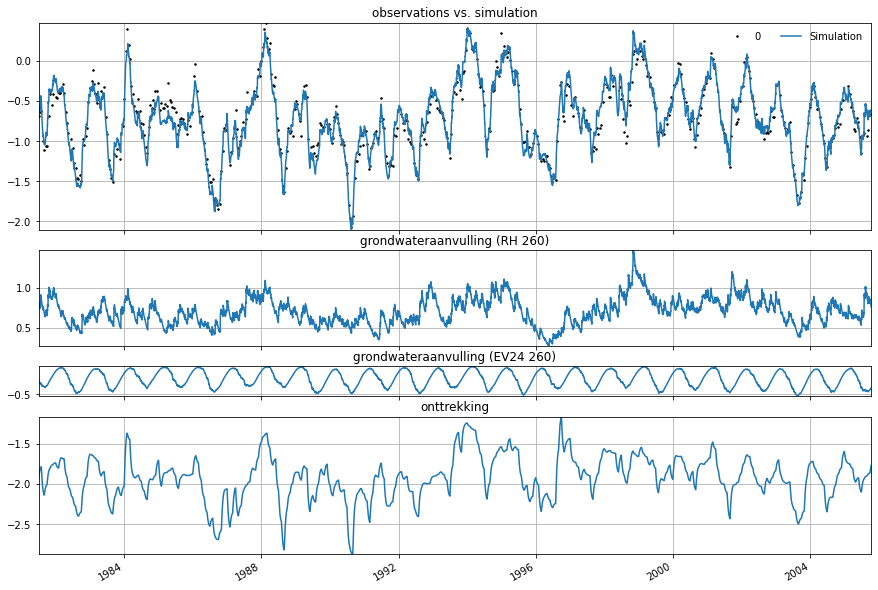

In [13]:
ml.plots.decomposition(figsize=(12,8));

Voor peilbuis PB2 is hetzelfde tijdreeksmodel opgezet. Hierbij zijn ook de neerslag en verdamping meegenomen als verklarende reeksen samen met de onttrekking. 

In [9]:
# opzetten model
ml2 = ps.Model(PB2)

# toevoegen van neerslag en verdamping als verklarende reeksen
sm1 = ps.StressModel2(stress=[neerslag, verdamping],
                    rfunc=ps.Gamma,
                    name='grondwateraanvulling',
                    settings=('prec', 'evap'))
ml2.add_stressmodel(sm1)

# toevoegen van onttrekking als verklarende reeks
sm2 = ps.StressModel(stress=well / 1e6,
                    rfunc=ps.Gamma,
                    name='onttrekking',
                    settings='well',
                    up=False)
ml2.add_stressmodel(sm2)

# oplossen van het tijdreeksmodel
ml2.solve()

# simuleren van de grondwaterstand
gws_simulatie2 = ml2.simulate()

INFO: Cannot determine frequency of series 0: freq=None. The time series is irregular.
INFO: Inferred frequency for time series RH 260: freq=D
INFO: Inferred frequency for time series EV24 260: freq=D
INFO: Inferred frequency for time series Extraction_2: freq=D


Fit report 0                                Fit Statistics
nfev     50                     EVP                     84.17
nobs     386                    R2                       0.84
noise    True                   RMSE                     0.11
tmin     1981-01-19 00:00:00    AIC                     14.92
tmax     1997-12-18 00:00:00    BIC                     50.53
freq     D                      Obj                      0.59
warmup   3650 days 00:00:00     ___                          
solver   LeastSquares           Interpolated               No

Parameters (9 were optimized)
                           optimal   stderr     initial  vary
grondwateraanvulling_A  393.126609  ±12.03%  201.630508  True
grondwateraanvulling_n    1.006147   ±2.79%    1.000000  True
grondwateraanvulling_a  135.471622  ±15.03%   10.000000  True
grondwateraanvulling_f   -0.568419  ±13.36%   -1.000000  True
onttrekking_A           -20.009036  ±14.07% -124.747493  True
onttrekking_n             1.676295  ±69.81

Te zien is dat het tijdreeksmodel een hoge verklaarde variantie en R$^2$ heeft maar lager dan het geval is bij PB1.

De decompositie van het tijdreeksmodel voor PB2 is te zien in de onstaande afbeelding. Hier is het effect van elke invoerreeks te zien volgens de modellering. Hierbij is te zien dat ten gevolge van de onttrekking de stijghoogte wordt verlaagt tussen de circa -0.3 en -0.8 m. Dit is significant lager dan de verlaging die bepaald is ter plaatse van PB1. Op basis van de gegevens is dit beeld logisch, PB2 staat immers verder van de onttrekking dan PB1, dit komt overeen met de hydrologische verwachting.

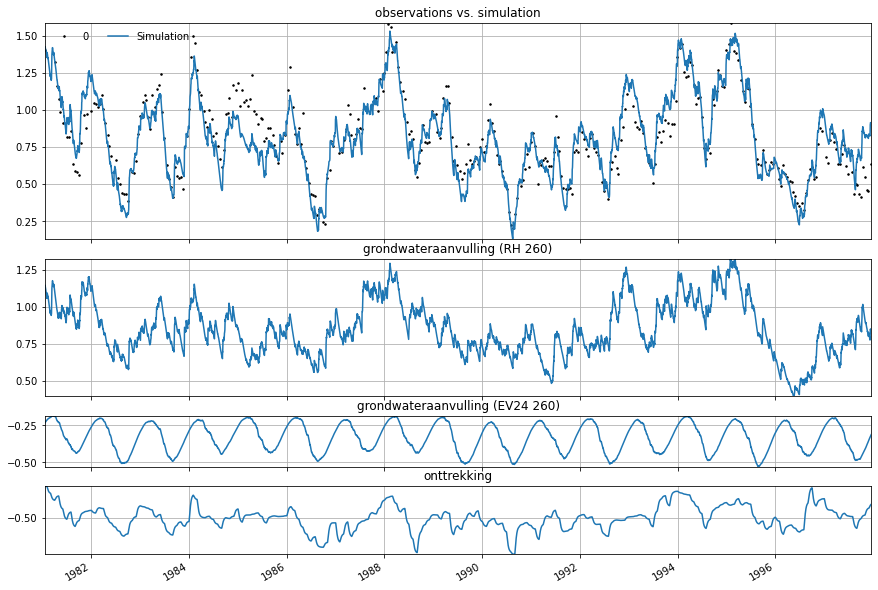

In [21]:
ml2.plots.decomposition(figsize=(12,8));

Voor peilbuis PB2 is hetzelfde tijdreeksmodel opgezet. Hierbij zijn ook de neerslag en verdamping meegenomen als verklarende reeksen samen met de onttrekking. 

In [22]:
# opzetten model
ml3 = ps.Model(PB3)

# toevoegen van neerslag en verdamping als verklarende reeksen
sm1 = ps.StressModel2(stress=[neerslag, verdamping],
                    rfunc=ps.Gamma,
                    name='grondwateraanvulling',
                    settings=('prec', 'evap'))
ml3.add_stressmodel(sm1)

# toevoegen van onttrekking als verklarende reeks
sm2 = ps.StressModel(stress=well / 1e6,
                    rfunc=ps.Hantush,
                    name='onttrekking',
                    settings='well',
                    up=False)
ml3.add_stressmodel(sm2)

# oplossen van het tijdreeksmodel
ml3.solve()

# simuleren van de grondwaterstand
gws_simulatie3 = ml3.simulate()

Fit report 0                                     Fit Statistics
nfev     26                     EVP                          72.50
nobs     708                    R2                            0.72
noise    True                   RMSE                          0.12
tmin     1971-06-02 00:00:00    AIC                          13.35
tmax     2002-09-30 00:00:00    BIC                          54.41
freq     D                      Obj                           2.22
warmup   3650 days 00:00:00     ___                               
solver   LeastSquares           Interpolated                    No

Parameters (9 were optimized)
                            optimal       stderr     initial  vary
grondwateraanvulling_A   361.670560       ±9.01%  201.630508  True
grondwateraanvulling_n     0.912094       ±2.86%    1.000000  True
grondwateraanvulling_a   154.975861      ±13.87%   10.000000  True
grondwateraanvulling_f    -0.591950      ±12.09%   -1.000000  True
onttrekking_A           -508.10473

Te zien is dat het tijdreeksmodel een hoge verklaarde variantie en R$^2$ heeft maar lager dan het geval is bij PB1 en PB2. In het overzicht van de optimalisatie is te zien dat de optimalisatie voor de parameters van de responsfunctie van de onttrekking zeer hoge onzekerheden heeft, tot > 10000%. 

De decompositie van het tijdreeksmodel voor PB3 is te zien in de onstaande afbeelding. Hier is het effect van elke invoerreeks te zien volgens de modellering. Hierbij is te zien dat de verlaging ten gevolge van de onttrekking nauwelijks zichtbaar is op deze schaal. Het effect wat bepaald is <0.003 m. Dit suggereert dat ter plaatse van PB3 de onttrekking geen verklarende reeks is voor de gemeten grondwaterstand. 

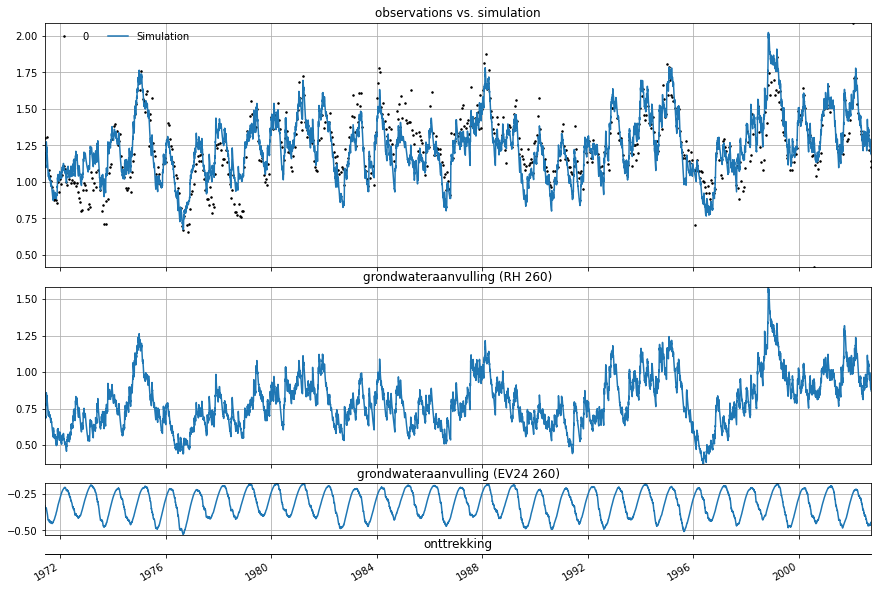

In [15]:
ml3.plots.decomposition(figsize=(12,8));

Om te controleren of de ontrekking inderdaad weinig effect op de grondwaterstand in PB3 wordt nogmaals een tijdreeksmodel opgesteld maar nu zonder de onttrekking. De resultaten hiervan zijn te zien in de onderstaande tabel.

In [25]:
# opzetten model
ml3_n = ps.Model(PB3)

# toevoegen van neerslag en verdamping als verklarende reeksen
sm1 = ps.StressModel2(stress=[neerslag, verdamping],
                    rfunc=ps.Gamma,
                    name='grondwateraanvulling',
                    settings=('prec', 'evap'))
ml3_n.add_stressmodel(sm1)



# oplossen van het tijdreeksmodel
ml3_n.solve()

# simuleren van de grondwaterstand
gws_simulatie3_n = ml3_n.simulate()

Fit report 0                                Fit Statistics
nfev     20                     EVP                     72.45
nobs     708                    R2                       0.72
noise    True                   RMSE                     0.12
tmin     1971-06-02 00:00:00    AIC                      7.34
tmax     2002-09-30 00:00:00    BIC                     34.72
freq     D                      Obj                      2.22
warmup   3650 days 00:00:00     ___                          
solver   LeastSquares           Interpolated               No

Parameters (6 were optimized)
                           optimal   stderr     initial  vary
grondwateraanvulling_A  360.003964   ±7.98%  201.630508  True
grondwateraanvulling_n    0.913009   ±2.85%    1.000000  True
grondwateraanvulling_a  153.569464  ±13.07%   10.000000  True
grondwateraanvulling_f   -0.590153  ±11.95%   -1.000000  True
constant_d                0.762291   ±7.79%    1.231875  True
noise_alpha              54.579958  ±11.68

In de resultaten is te zien dat de verklaarde variantie en R$^2$ vergelijkbaar zijn met het model resultaat van het tijdreeksmodel met onttrekking. Dit suggereert dat het effect ter plaatse van deze peilbuis inderdaad niet significant is.

In de onderstaande tabel zijn de gemiddelde verlagingen opgenomen zoals deze met de tijdreeksanalyse zijn bepaald. 


| Peilbuis      | Afstand  [m]  | Gemiddeld effect  [m]  | 
| ------------- |:-------------:|:-------------:| 
| PB1           | 112           | -1.92         | 
| PB2           | 180           | -0.50         | 
| PB3           | 321           | -0.0007       |

In de onderstaande grafiek zijn de gemiddeld bepaalde verlagingen uitgezet tegen de afstand tot de onttrekkingsput. Het watervoerendpakket in de omgeving is uniform, daarom is de verwachting dat op een afstand van 500 m, de afstand tussen het natuurgebied en de onttrekking, geen significant effect optreedt. 

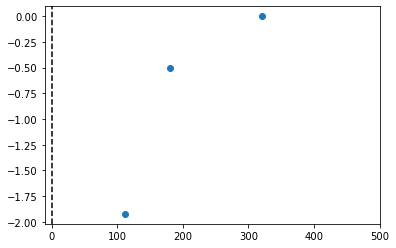

In [46]:
gem_1 = ml.get_contribution('onttrekking').mean()
gem_2 = ml2.get_contribution('onttrekking').mean()
gem_3 = ml3.get_contribution('onttrekking').mean()

dis_1 = 112
dis_2 = 180
dis_3 = 321

plt.plot(np.array([dis_1, dis_2, dis_3]),
         np.array([gem_1, gem_2, gem_3]), color='C0', marker='o', ls='')
plt.axvline(x=0, ls='--', color='k')
plt.xlim(-10, 500);